# GBDT
## Gradient Boosting Machine，GBM

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mlp
import seaborn as sns
import re, pip, conda
import time
import os

d:\CODE\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


- **Weak estimator**

> GBDT's weak evaluator output type is no longer consistent with the overall integration algorithm output type. For the AdaBoost or random forest algorithm, when the ensemble algorithm performs a regression task, the weak evaluator is also a regressor, and when the ensemble algorithm performs a classification task, the weak evaluator is also a classifier. But for GBDT, regardless of whether GBDT is performing regression/classification/sorting tasks as a whole, the weak evaluator must be a regressor. GBDT outputs specific classification results through the sigmoid or softmax function, but the actual weak evaluator must be a regressor.

<br>

- **Loss function $L(x,y)$**

> In GBDT, the scope of the loss function is no longer limited to a fixed or single loss function, but is extended to any differentiable function based on mathematical principles. Therefore, there are many optional loss functions in the GBDT algorithm, and the mathematical process of actual calculation of GBDT has nothing to do with the expression of the loss function. <br>

<br>

- **Fit Residuals**

> GBDT still adaptively adjusts the construction of weak evaluators, but it does not **indirectly** affect subsequent weak evaluators by adjusting data distribution like AdaBoost. In contrast, GBDT directly affects the structure of subsequent weak evaluators by modifying the fitting objectives of subsequent weak evaluators. <br><br>
> Specifically, in AdaBoost, the sample weight needs to be modified each time before establishing a weak evaluator, and the sample $X$ and the corresponding $y$ are used to establish the weak evaluator. In GBDT, we do not modify the sample Weight, but what is used to build the weak estimator each time is the sample $X$ and the difference between the current integrated output $H(x_i)$ and the real label $y$ ($y - H(x_i)$). This difference is mathematically called the residual (Residual), so **GBDT does not modify the sample weight, but affects the subsequent weak evaluator structure by fitting the residual**. <br>

<br>

- **Sampling**

> GBDT adds the idea of random sampling in random forest, allowing samples and features to be sampled before each tree building to increase the independence between weak evaluators (therefore, there can be out-of-bag data sets). Although the Boosting algorithm does not rely on a large-scale approach similar to Bagging to reduce variance, since the output of the Boosting algorithm is a weighted summation of the weak estimator results, Boosting can in principle also obtain the benefits brought by "average" Small variance bonus. When the performance of the weak evaluator is not stable, using a method similar to random forest can further increase the stability of the Boosting algorithm.

In [2]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import cross_validate, KFold

In [3]:
data = pd.read_csv(r"D:\Practice\Machine Learning\datasets\House Price\train_encode.csv",index_col=0)

In [4]:
data.head()

,Id,住宅类型,住宅区域,街道接触面积(英尺),住宅面积,街道路面状况,巷子路面状况,住宅形状(大概),住宅现状,水电气,...,泳池面积,泳池质量,篱笆质量,其他配置,其他配置的价值,销售月份,销售年份,销售类型,销售状态,SalePrice
0,0.0,5.0,3.0,36.0,327.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,8.0,4.0,208500
1,1.0,0.0,3.0,51.0,498.0,1.0,0.0,3.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,8.0,4.0,181500
2,2.0,5.0,3.0,39.0,702.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.0,2.0,8.0,4.0,223500
3,3.0,6.0,3.0,31.0,489.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.0,0.0,140000
4,4.0,5.0,3.0,55.0,925.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,2.0,8.0,4.0,250000


In [5]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [6]:
X.shape

(1460, 80)

In [7]:
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [9]:
cv = KFold(n_splits=5, shuffle=True, random_state=21)

def RMSE(result, name):
    return abs(result[name].mean())

In [10]:
gbr = GBR(random_state=12)
result_gbr = cross_validate(gbr,X,y,cv=cv,
                            scoring="neg_root_mean_squared_error",
                            return_train_score=True,
                            verbose=True,
                            n_jobs=10)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    4.5s finished


In [11]:
RMSE(result_gbr,"train_score")

13997.14537743202

In [12]:
RMSE(result_gbr,"test_score")

27180.30154302002

In [13]:
modelname = ["GBDT","RF","AdaBoost","RF-TPE","Ada-TPE"]

models = [GBR(random_state=21)
         ,RFR(random_state=21,n_jobs=-1)
         ,ABR(random_state=21)
         ,RFR(n_estimators=89, max_depth=22, max_features=14, min_impurity_decrease=0
              ,random_state=21, verbose=False, n_jobs=-1)
         ,ABR(n_estimators=39, learning_rate=0.94,loss="exponential"
              ,random_state=21)]

colors = ["green","gray","orange","red","blue"]

In [14]:
for name,model in zip(modelname,models):
    start = time.time()
    result = cross_validate(model,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
    end = time.time()-start
    print(name)
    print("\t train_score:{:.3f}".format(RMSE(result,"train_score")))
    print("\t test_score:{:.3f}".format(RMSE(result,"test_score")))
    print("\t time:{:.2f}s".format(end))
    print("\n")

GBDT
	 train_score:13997.145
	 test_score:26755.685
	 time:4.80s


RF
	 train_score:11609.644
	 test_score:29464.653
	 time:4.05s


AdaBoost
	 train_score:27759.099
	 test_score:34311.141
	 time:0.44s


RF-TPE
	 train_score:11152.105
	 test_score:28459.844
	 time:1.84s


Ada-TPE
	 train_score:27367.539
	 test_score:33986.483
	 time:0.33s




|算法|RF|AdaBoost|GBDT|RF<br>(TPE)|AdaBoost<br>(TPE)|
|:-:|:-:|:-:|:-:|:-:|:-:|
|5折验证<br>运行时间|4.05s|0.44s|1.84s|1.84s|0.33s|
|最优分数<br>(RMSE)|29464.653|34311.141|26755.685|28459.844|33986.483|

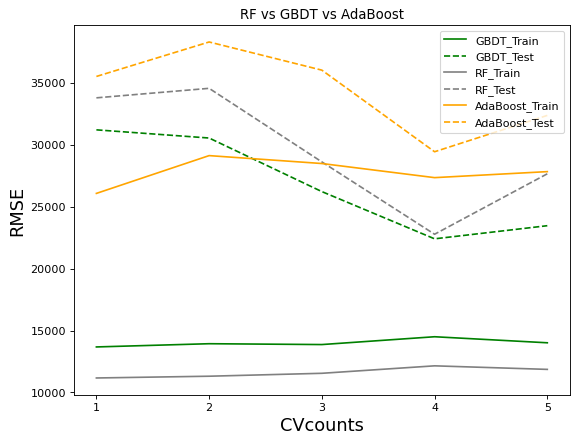

In [15]:
xaxis = range(1,6)
plt.figure(figsize=(8,6),dpi=80)

for name,model,color in zip(modelname[:3],models[:3],colors[:3]):
    result = cross_validate(model,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                            ,return_train_score=True
                            ,verbose=False
                            ,n_jobs=-1)
    plt.plot(xaxis,abs(result["train_score"]), color=color, label = name+"_Train")
    plt.plot(xaxis,abs(result["test_score"]), color=color, linestyle="--",label = name+"_Test")

plt.xticks([1,2,3,4,5])
plt.xlabel("CVcounts",fontsize=16)
plt.ylabel("RMSE",fontsize=16)
plt.title("RF vs GBDT vs AdaBoost")
plt.legend()
plt.show()

**The principle of the Boosting algorithm determines that the Boosting algorithm is less likely to overfit**

---

- ### GBDT Classification

In [16]:
X_clf = data.iloc[:,:-2]
y_clf = data.iloc[:,-2]

In [17]:
np.unique(y_clf) 

array([0., 1., 2., 3., 4., 5.])

In [18]:
clf = GBC(random_state=21) #实例化
cv = KFold(n_splits=5,shuffle=True,random_state=21)
result_clf = cross_validate(clf,X_clf,y_clf,cv=cv
                            ,return_train_score=True
                            ,verbose=True
                            ,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


In [19]:
result_clf

{'fit_time': array([8.80534792, 8.82468891, 8.7831459 , 8.76360846, 8.6946969 ]),
 'score_time': array([0.00209713, 0.010005  , 0.        , 0.        , 0.01256895]),
 'test_score': array([0.89726027, 0.88013699, 0.91438356, 0.89041096, 0.89041096]),
 'train_score': array([0.99571918, 0.99315068, 0.99229452, 0.99229452, 0.98972603])}

In [20]:
result_clf["train_score"].mean()

0.9926369863013699

In [21]:
result_clf["test_score"].mean()

0.8945205479452054

|类型|参数/属性|
|---|---|
|**迭代过程**|参数：n_estimators, learning_rate, **<font color="green">loss, alpha, init</font>**<br>属性：<font color="green">**loss_, init_, estimators_**</font>|
|**弱评估器结构**|<font color="green">**criterion**</font>, max_depth, min_samples_split, min_samples_leaf, <br>min_weight_fraction_leaf, max_leaf_nodes,<br>min_impurity_decrease|
|**提前停止**|参数：<font color="green">**validation_fraction, n_iter_no_change, tol**</font><br>属性：<font color="green">**n_estimators_**</font>|
|**弱评估器的训练数据**|参数：subsample, max_features, random_state<br>属性：<font color="green">**oob_improvement, train_score_**</font>|
|**其他**|ccp_alpha, warm_start|

-  `init`: input the estimator object that calculates the initial prediction result $H_0$.

In this parameter, you can enter any evaluator, the string "zero", or a None object. The default is a None object.
> When inputting any evaluator, the evaluator must have fit and predict_proba functions, that is, we can use decision trees, logistic regression and other models that can output probabilities. If you output a model that has been trained and finely tuned, it will lay a solid foundation for the GBDT tree. <br><br>
> Fill in the string "zero", which means setting $H_0 = 0$ to start iteration. <br><br>
> If not filled in, or filled in as a None object, sklearn will automatically select a default method in the class `DummyEstimator` to predict as the result of $H_0$. The `DummyEstimator` class is a class set in sklearn that uses ultra-simple rules for prediction. The most common rule is to randomly sample the results directly from the training set labels as the prediction label. There are also options such as selecting the mode as the prediction label.

Generally, during the use of the GBDT class, we will not actively adjust the parameter `init`, but when we have enough computing power to support hyperparameter search, we can make a choice on `init`.

In [22]:
from sklearn.tree import DecisionTreeRegressor as DTR

In [23]:
tree_reg = DTR(random_state=1412)
rf = RFR(n_estimators=89, max_depth=22, max_features=14, min_impurity_decrease=0
              ,random_state=1412, verbose=False, n_jobs=-1)

In [24]:
for init in [tree_reg,rf,"zero",None]:
    reg = GBR(init = init,random_state=1412)
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    result_reg = cross_validate(reg,X,y,cv=cv,scoring="neg_root_mean_squared_error"
                                ,return_train_score=True
                                ,verbose=False
                                ,n_jobs=-1)
    print("\n")
    print(RMSE(result_reg,"train_score"))
    print(RMSE(result_reg,"test_score"))



0.0
42065.93924112058


5669.291478825804
27210.35474496567


13990.791639702458
28739.882050269225


13990.790813889864
28783.954343252786


---

### 8 types of loss functions of GBDT

**Binary Classification Cross Entropy Loss**——<br><br>
$$L = -\left( y\log p(x) + (1 - y)\log(1 - p(x)) \right)$$

<br>Note that the input in the log must be a probability value. For logistic regression, the probability is the output of the algorithm, so we can think that $p = H(x)$ in logistic regression, but for GBDT, $p(x_i) = Sigmoid(H(x_i))$, this One thing must be noted.

<br>

**Multi-class cross entropy loss**, there are K categories in total——<br><br>

$$L = -\sum_{k=1}^Ky^*_k\log(P^k(x))$$

Among them, $P^k(x)$ is the probability value. For multi-class GBDT, $p^k(x) = Softmax(H^k(x))$. $y^*$ is the vector converted from the real label. For example, in the case of 3 classification, when the real label $y_i$ is 2, $y^*$ is [$y^*_{1}$,$y^*_{2}$,$y^*_{ 3}$], the values are:

|$y^*_{1}$|$y^*_{2}$|$y^*_{3}$|
|:-:|:-:|:-:|
|$0$|$1$|$0$|

**Two classification index loss**——<br><br>
$$L = e^{-yH(x)}$$

**Multi-category index loss**, there are K categories in total——<br><br>

$$
\begin{aligned}
L &=exp \left( -\frac{1}{K}\boldsymbol{y^* · H^*(x)} \right) \\ 
& = exp \left( -\frac{1}{K}(y^1H^1(x)+y^2H^2(x) \ + \  ... + y^kH^k(x)) \right)
\end{aligned}
$$

It should be noted that $y^*$ in exponential loss and $y^*$ in cross-entropy loss are not the same vector. We have already explained the cross-entropy loss in detail in the chapter of logistic regression, and the exponential loss in the chapter of AdaBoost, so we will not go into details here. It should be noted that the general gradient boosting classifier uses cross-entropy loss by default. If exponential loss is used, it is equivalent to executing the AdaBoost algorithm without weight adjustment.

regression `loss`{"squared_error", "absolute_error", "huber", "quantile"}，默认值="squared_error"

**平方误差**——<br><br>

$$L = \sum{(y_i - H(x_i))^2}$$

<br>

**绝对误差**——<br><br>

$$L = \sum{|y_i - H(x_i)|}$$

<br>

**Huber损失**——

$$L = \sum{l(y_i,H(x_i))}$$

其中$$l = \begin{split} 
\begin{cases}\frac{1}{2}(y_i - H(x_i))^2, & |y_i - H(x_i)|\leq\alpha \\
\alpha(|y_i - H(x_i)|-\frac{\alpha}{2}),& |y_i - H(x_i)|>\alpha \end{cases}\end{split}, \space \space \alpha \in (0, 1)$$

<br>

**quantile损失**——

$$L = \sum{l(y_i,H(x_i))}$$

其中$$l = \begin{split} 
\begin{cases}
    \alpha (y_i - H(x_i)), & y_i - H(x_i) > 0 \\
    0,    & y_i - H(x_i) = 0 \\
    (1-\alpha) (y_i - H(x_i)), & y_i - H(x_i) < 0
\end{cases}\end{split}, \space \space \alpha \in (0, 1)$$

其中$\alpha$是需要我们自己设置的超参数，由参数`alpha`控制。在huber损失中，alpha是阈值，在quantile损失中，alpha用于辅助计算损失函数的输出结果，默认为0.9。

- **Select squared error when you are highly concerned about outliers and want to work hard to predict the outliers**<br><br>
This is the case in most industries. In actual prediction, outliers are often more difficult to predict, so the difference between the predicted value and the true value of the outlier sample is generally larger. As the square of the difference between the predicted value and the true value, MSE will amplify the impact of outliers and make the algorithm evolve in the direction of learning outliers, which can help the algorithm better predict outliers.

- **When trying to eliminate the influence of outliers and pay more attention to non-outliers, choose absolute error**<br><br>
MAE treats all samples equally and only obtains the absolute value of all differences, so it will retain the original state of sample differences. Compared with its MSE, MAE is completely insensitive to outliers, which can effectively reduce GBDT's attention on outliers.

- **When trying to balance outliers and non-outliers and have no preference, choose Huber or Quantileloss**<br><br>
Huberloss loss combines MSE and MAE. In Huber's formula, when the difference between the predicted value and the true value is greater than the threshold, the absolute value is taken, and when it is less than the threshold, the square is taken. In real data, the difference of some outliers will be greater than the threshold, and the difference of some outliers will be less than the threshold. Therefore, compared with MAE that takes all absolute values, Huberloss will square the true prediction difference of some outliers, which is equivalent to This amplifies the impact of outliers (but this impact is not as large as in MSE). Therefore, HuberLoss is a loss that is located between MSE and MAE and is relatively insensitive to outliers.

|类型|参数/属性|
|---|---|
|**迭代过程**|参数：<br><br>&emsp;n_estimators：集成算法中弱评估器数量，对Boosting算法而言为实际迭代次数<br><br>&emsp;learning_rate：Boosting算法中的学习率，影响弱评估器结果的加权求和过程<br><br>&emsp;<font color="green">**loss, alpha**</font>：需要优化的损失函数，以及特定损失函数需要调节的阈值<br><br>&emsp;<font color="green">**init**</font>：初始化预测结果$H_0$的设置<br><br>属性：<br><br>&emsp;<font color="green">**loss_**</font>：返回具体的损失函数对象<br><br>&emsp;<font color="green">**init_**</font>：返回具体的初始化设置<br><br>&emsp;<font color="green">**estimators_**</font>：返回实际建立的评估器列表<br><br>&emsp;n_estimators_：返回实际迭代次数|

---

### weak estimator

|类型|参数|
|----|----|
|**弱评估器结构**|<font color="green">**criterion**</font>：弱评估器分枝时的不纯度衡量指标<br><br>max_depth：弱评估器被允许的最大深度，默认3<br><br>min_samples_split：弱评估器分枝时，父节点上最少要拥有的样本个数<br><br>min_samples_leaf：弱评估器的叶子节点上最少要拥有的样本个数<br><br>min_weight_fraction_leaf：当样本权重被调整时，叶子节点上最少要拥有的样本权重<br><br>max_leaf_nodes：弱评估器上最多可以有的叶子节点数量<br><br>min_impurity_decrease：弱评估器分枝时允许的最小不纯度下降量|

这些参数在随机森林中的**用法与默认值**与决策树类`DecisionTreeRegressor`中完全一致，专门用于对决策树进行剪枝、控制单个弱评估器的结构，考虑到大家在决策树中已经充分掌握这些参数，我们不再对这些参数一一进行详细说明了。在这里，需要重点说明的有两部分内容，一部分梯度提升树中默认的弱评估器复杂度所带来的问题，另一部分则是梯度提升树独有的不纯度衡量指标。

**Impurity reduction based on Friedman mean square error**
$$\frac{w_lw_r}{w_l \space + \space w_r} * \left( \frac{\sum_l{(r_i - \hat{y_i})^2}}{w_l} - \frac{\sum_r{(r_i - \hat{y_i})^2}}{w_r}\right)^2$$
**<center>左右叶子节点上样本量的调和平均 * (左叶子节点上均方误差 - 右叶子节点上的均方误差)^2</center>**

---

### early stop

- **当GBDT已经达到了足够好的效果（非常接近收敛状态），持续迭代下去不会有助于提升算法表现**
- **GBDT还没有达到足够好的效果（没有接近收敛），但迭代过程中呈现出越迭代算法表现越糟糕的情况**
- **虽然GBDT还没有达到足够好的效果，但是训练时间太长/速度太慢，我们需要重新调整训练**
- ![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/2021MachineLearning/Ensembles/Public/53.PNG)`

In [25]:
reg1 = GBR(n_estimators=100
          ,validation_fraction=0.1,n_iter_no_change=3,tol=0.01
          ,random_state=1412).fit(X,y)
reg2 = GBR(n_estimators=100,random_state=1412).fit(X,y)

In [26]:
reg1.n_estimators_ #打开提前停止

63

In [27]:
reg2.n_estimators_ #关闭提前停止

100

In [28]:
import time
from sklearn.model_selection import train_test_split

In [29]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=1412)

In [30]:
start = time.time()
reg1 = GBR(n_estimators=1000
          ,validation_fraction=0.2,n_iter_no_change=10,tol=0.001
          ,random_state=1412).fit(Xtrain,Ytrain)
print(time.time()-start)

1.1602890491485596


In [31]:
start = time.time()
reg2 = GBR(n_estimators=1000,random_state=1412).fit(Xtrain,Ytrain)
print(time.time()-start)

10.346487760543823


In [36]:
reg1.n_estimators_ #打开提前停止

109

In [37]:
reg1.score(Xtest,Ytest) #R2

0.897711170231429

In [38]:
reg2.n_estimators_ #关闭提前停止

1000

In [39]:
reg2.score(Xtest,Ytest)

0.89927123751538

When should I use early stopping? Generally there are the following scenarios:

- When the amount of data is very large and the training speed is very slow visible to the naked eye, enable early stopping to save computing time<br><br>
- When the n_estimators parameter range is extremely wide and may involve 500~1000 trees, enable early stopping to find possible smaller n_estimators values<br><br>
- When the amount of data is very small and the model is likely to fall into overfitting quickly, enable early stopping to prevent overfitting<br>

|类型|参数|
|----|----|
|**提前停止**|<font color="green">**validation_fraction**</font>：从训练集中提取出、用于提前停止的验证数据占比<br><br><font color="green">**n_iter_no_change**</font>：当验证集上的损失函数值连续n_iter_no_change次没有下降<br>或下降量不达阈值时，则触发提前停止<br><br><font color="green">**tol**</font>：损失函数下降量的最小阈值|

---

### Out-of-bag data for gradient boosting trees

**Each time a tree is built, GBDT will use the out-of-bag data of the current tree to verify the model after building the new tree to compare whether the overall level of the model has improved after the new weak estimator is created, and retain the improvement or decline. result**
In GBDT, the random sampling ratio of the data with replacement is determined by the parameter `subsample`. When this parameter is set to 1, no sampling is performed and the entire data set is used directly for training. When this parameter is set to a number between (0,1), a random boosting tree is used to sample samples before each round of tree building. The proportion of sampling with replacement for features is determined by the parameter `max_features`, and the random pattern is determined by the parameter `random_state`. The usage rules of these two parameters in GBDT are completely consistent with those in random forest.

It should be noted that if `subsample`<1, that is, when there is random sampling with replacement, when the amount of data is large enough and the number of samplings is large enough, about 37% of the data will be missed "out of bag" (out of bag). ) did not participate in the training.

In [40]:
reg = GBR(n_estimators=500,learning_rate=0.1
          ,subsample=0.3 #每次建树只抽取30%的数据进行训练
          ,random_state=1412).fit(X,y)

In [41]:
reg.oob_improvement_.shape #袋外数据上的损失函数变化量

(500,)

In [42]:
reg.train_score_.shape #训练集上的损失函数变化量

(500,)

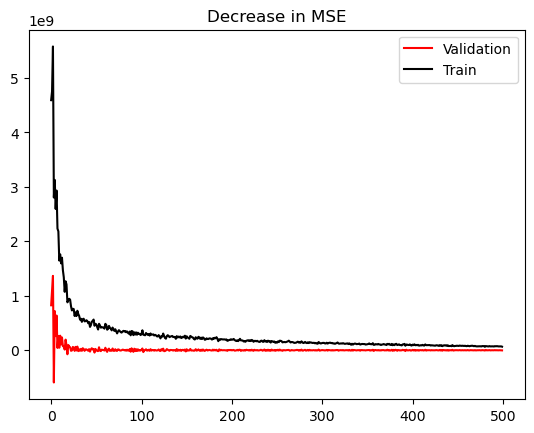

In [43]:
plt.plot(range(500),reg.oob_improvement_,color="red",label="Validation")
plt.plot(range(500),reg.train_score_,color="k",label="Train")
plt.title("Decrease in MSE")
plt.legend()

In [44]:
reg = GBR(n_estimators=500,learning_rate=0.1
          ,tol=1e-6 #非常非常低的阈值
          ,n_iter_no_change=5
          ,validation_fraction = 0.3
          ,subsample=0.3
          ,random_state=1412).fit(X,y)

In [45]:
reg.oob_improvement_.shape #实际我只迭代了69次

(69,)

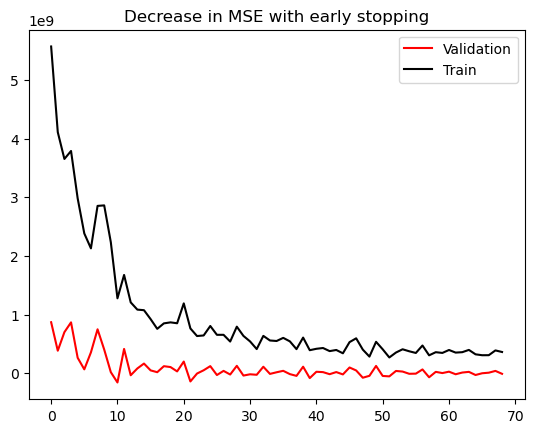

In [46]:
plt.plot(range(69),reg.oob_improvement_,color="red",label="Validation")
plt.plot(range(69),reg.train_score_,color="k",label="Train")
plt.title("Decrease in MSE with early stopping")
plt.legend()

|类型|参数|
|----|----|
|**弱评估器的训练数据**|参数：<br><br>&emsp;subsample：每次建树之前，从全数据集中进行有放回随机抽样的比例<br><br>&emsp;max_features：每次建树之前，从全特征中随机抽样特征进行分枝的比例<br><br>&emsp;random_state：随机数种子，控制整体随机模式<br><br>属性：<br><br>&emsp;<font color="green">**oob_improvement**</font>：每次建树之后相对于上一次袋外分数的增减<br><br>&emsp;<font color="green">**train_score_**</font>：每次建树之后相对于上一次验证时袋内分数的增减|

---

### class_weight & n_jobs

|类型|参数/属性|
|---|---|
|**迭代过程**|参数：n_estimators, learning_rate, <font color="green">**loss, alpha, init**</font><br>属性：<font color="green">**loss_, init_, estimators_**</font>|
|**弱评估器结构**|<font color="green">**criterion**</font>, max_depth, min_samples_split, min_samples_leaf, <br>min_weight_fraction_leaf, max_leaf_nodes,<br>min_impurity_decrease|
|**提前停止**|参数：<font color="green">**validation_fraction, n_iter_no_change, tol**</font><br>属性：<font color="green">**n_estimators_**</font>|
|**弱评估器的训练数据**|参数：subsample, max_features, random_state<br>属性：<font color="green">**oob_improvement, train_score_**</font>|
|**其他**|ccp_alpha, warm_start|

---

### GBDT parameter space and hyperparameter optimization

|影响力|参数|
|:-:|:-:|
|⭐⭐⭐⭐⭐<br>几乎总是具有巨大影响力|n_estimators（整体学习能力）<br>learning_rate（整体学习速率）<br>max_features（随机性）<br>|
|⭐⭐⭐⭐<br>大部分时候具有影响力|init（初始化）<br>subsamples（随机性）<br>loss（整体学习能力）|
|⭐⭐<br>可能有大影响力<br>大部分时候影响力不明显|max_depth（粗剪枝）<br>min_samples_split（精剪枝）<br>min_impurity_decrease（精剪枝）<br>max_leaf_nodes（精剪枝）<br>criterion（分枝敏感度）|
|⭐<br>当数据量足够大时，几乎无影响|random_state<br>ccp_alpha（结构风险）|

|参数|范围|
|:-:|:-:|
|`loss`|回归损失中4种可选损失函数<br>["squared_error","absolute_error", "huber", "quantile"]|
|`criterion`|全部可选的4种不纯度评估指标<br>["friedman_mse", "squared_error", "mse", "mae"]|
|`init`|HyperOpt不支持搜索，手动调参|
|`n_estimators`|经由提前停止确认中间数50，最后范围定为(25,200,25)|
|`learning_rate`|以1.0为中心向两边延展，最后范围定为(0.05,2.05,0.05)<br>*如果算力有限，也可定为(0.1,2.1,0.1)|
|`max_features`|所有字符串，外加sqrt与auto中间的值|
|`subsample`|subsample参数的取值范围为(0,1]，因此定范围(0.1,0.8,0.1)<br>*如果算力有限，也可定为(0.5,0.8,0.1)|
|`max_depth`|以3为中心向两边延展，右侧范围定得更大。最后确认(2,30,2)|
|`min_impurity_decrease`|只能放大、不能缩小的参数，先尝试(0,5,1)范围|

---

###  Optimize GBDT based on TPE

In [2]:
#日常使用库与算法
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mlp
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.model_selection import cross_validate, KFold

#导入优化算法
import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss

In [3]:
data = pd.read_csv(r"D:\Practice\Machine Learning\datasets\House Price\train_encode.csv",index_col=0)

In [4]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [5]:
#benchm ark
rf = RFR(n_estimators=89, max_depth=22, max_features=14,min_impurity_decrease=0
         ,random_state=1412, verbose=False, n_jobs=-1)

|参数|范围|
|:-:|:-:|
|`loss`|回归损失中4种可选损失函数<br>["squared_error","absolute_error", "huber", "quantile"]|
|`criterion`|全部可选的4种不纯度评估指标<br>["friedman_mse", "squared_error", "mse", "mae"]|
|`init`|HyperOpt不支持搜索，手动调参|
|`n_estimators`|经由提前停止确认中间数50，最后范围定为(25,200,25)|
|`learning_rate`|以1.0为中心向两边延展，最后范围定为(0.05,2.05,0.05)<br>*如果算力有限，也可定为(0.1,2.1,0.1)|
|`max_features`|所有字符串，外加sqrt与auto中间的值|
|`subsample`|subsample参数的取值范围为(0,1]，因此定范围(0.1,0.8,0.1)<br>*如果算力有限，也可定为(0.5,0.8,0.1)|
|`max_depth`|以3为中心向两边延展，右侧范围定得更大。最后确认(2,30,2)|
|`min_impurity_decrease`|只能放大、不能缩小的参数，先尝试(0,5,1)范围|

In [22]:
param_grid_simple = {'n_estimators': hp.quniform("n_estimators",25,200,25)
                  ,"lr": hp.quniform("learning_rate",0.05,2.05,0.05)
                  ,"criterion": hp.choice("criterion",{'friedman_mse', 'squared_error'})
                  ,"loss":hp.choice("loss",["squared_error","absolute_error", "huber", "quantile"])
                  ,"max_depth": hp.quniform("max_depth",2,30,2)
                  ,"subsample": hp.quniform("subsample",0.1,0.8,0.1)
                  ,"max_features": hp.choice("max_features",["log2","sqrt",16,32,64,"auto"])
                  ,"min_impurity_decrease":hp.quniform("min_impurity_decrease",0,5,1)
                 }

In [23]:
len(range(25,200,25)) * len(np.arange(0.05,2.05,0.05)) * 4 * 4 * len(range(2,30,2)) * len(np.arange(0.1,0.8,0.1)) * 6 * len(range(0,5,1))

13171200

In [24]:
def param_hyperopt(max_evals=100):
    
    #保存迭代过程
    trials = Trials()
    
    #设置提前停止
    early_stop_fn = no_progress_loss(100)
    
    #定义代理模型
    params_best = fmin(hyperopt_objective
                       , space = param_grid_simple
                       , algo = tpe.suggest
                       , max_evals = max_evals
                       , verbose=True
                       , trials = trials
                       , early_stop_fn = early_stop_fn
                      )
    
    #打印最优参数，fmin会自动打印最佳分数
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

In [25]:
def hyperopt_validation(params):    
    reg = GBR(n_estimators = int(params["n_estimators"])
              ,learning_rate = params["learning_rate"]
              ,criterion = params["criterion"]
              ,loss = params["loss"]
              ,max_depth = int(params["max_depth"])
              ,max_features = params["max_features"]
              ,subsample = params["subsample"]
              ,min_impurity_decrease = params["min_impurity_decrease"]
              ,init = rf
              ,random_state=1412 #GBR中的random_state只能够控制特征抽样，不能控制样本抽样
              ,verbose=False)
    cv = KFold(n_splits=5,shuffle=True,random_state=1412)
    validation_loss = cross_validate(reg,X,y
                                     ,scoring="neg_root_mean_squared_error"
                                     ,cv=cv
                                     ,verbose=False
                                     ,n_jobs=-1
                                    )
    return np.mean(abs(validation_loss["test_score"]))

In [26]:
params_best, trials = param_hyperopt(30) #使用小于0.1%的空间进行训练

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

job exception: The 'max_features' parameter of cross_validate must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.



  0%|          | 0/30 [00:03<?, ?trial/s, best loss=?]


InvalidParameterError: The 'max_features' parameter of cross_validate must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.

In [ ]:
params_best #注意hp.choice返回的结果是索引，而不是具体的数字

- 《贪心函数估计：一种梯度提升机器》<br>
Friedman, J. H. (February 1999). "Greedy Function Approximation: A Gradient Boosting Machine"

- 《随机梯度提升》<br>
Friedman, J. H. (March 1999). "Stochastic Gradient Boosting"

- 《梯度下降式提升算法》<br>
Mason, L.; Baxter, J.; Bartlett, P. L.; Frean, Marcus (1999). "Boosting Algorithms as Gradient Descent"

- 《函数空间中的梯度下降式提升算法》<br>
Mason, L.; Baxter, J.; Bartlett, P. L.; Frean, Marcus (May 1999). "Boosting Algorithms as Gradient Descent in Function Space"